In [1]:
import pandas_gbq as pbq
import pandas as pd
import warnings
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import base64
from pathlib import Path
import warnings

from appscript import app, k
from mactypes import Alias
from pathlib import Path


font_style = 'Helvetica'
    
mpl.rcParams['font.family'] = font_style
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.titleweight"] = "bold"

try:
    plt.style.use(r'C:\Users\KamilcS\OneDrive - Universal Music Group\projects\matplotlibrc')
except:
    plt.style.use('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/matplotlibrc')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

palette = json.loads(open("../palette.json").read())
report_date = datetime.now().strftime('%Y-%m-%d')


# CHRIS TOMLIN
# Emmanuel: Christmas Songs of Worship (Deluxe)
# 9075957 6041
#

In [2]:
weeks = pd.read_csv(
    '/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/ADHOC_ALBUMS_COMPARE/weeks.csv',
    parse_dates=['date', 'we_date'],
    dtype=str
    )
weeks['week'] = weeks['week'].str.zfill(2)
weeks['global_week'] = weeks['year'] + weeks['week']

weeks_dict = weeks.set_index('date')[['global_week', 'we_date']].to_dict()


# weeks_dict

In [255]:
# read album JSON dict
album_dict = json.loads(open('/Users/KamilcS/Library/CloudStorage/OneDrive-UniversalMusicGroup/projects/ALBUM_DATA.json').read())

# store copy of said JSON to local repo
with open("./ALBUM_DATA.json", "w") as outfile:
    json.dump(album_dict, outfile)

# album_dict

In [6]:
def pull_down_data(master_artist, year):

    query = open('./queries/artist_full_pull.sql').read()
    query_formatted = query.format(
        master_artist= master_artist,
        start_date = f'{year}-01-01',
        end_date = f'{year}-12-31'
    )


    df = pbq.read_gbq(query_formatted, project_id='umg-us')
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])

    df['album_adjusted_units'] = np.where(
        df['usage_group'].str.contains('Streaming (Premium)', regex=False), df['units'].div(1250), 
            np.where(df['usage_group'].str.contains('Streaming (Free)', regex=False), df['units'].div(3750),
                np.where(
                    df['product_type'].str.contains('Video', regex=False), df['units'].div(3750),
                        np.where(
                            df['usage_group'].str.contains('Download (Track)', regex=False), df['units'].div(10), df['units']
                        )
                    )
                )
            )

    df['raw_stream_units'] = np.where(
        df['usage_group'].str.contains('Streaming', regex=False), df['units'], 0
    )

    df['product_type'] = np.where(
        df['product_type'] == 'Track', 'Audio', df['product_type']

    )
    # Small accounts as Others
    big_accounts = df.groupby('account').album_adjusted_units.sum()[df.groupby('account').album_adjusted_units.sum() > 1000].index
    df['account'] = np.where(
        df['account'].isin(big_accounts), df['account'], 'Others'
    )
    # US and XUS distinction
    df['country'] = np.where(
        df['country'] == 'United States', 'US', 'XUS'
    )
    df['year'] = df['transaction_date'].dt.year
    df['month'] = df['transaction_date'].dt.month
    df['day'] = df['transaction_date'].dt.day
    df['month_day'] = df['transaction_date'].dt.strftime('%b-%d')
    
    # FIX FOR AMY GRANT ALBUM, STRAND APOSTROPHES
    # df['master_track'] = df['master_track'].str.replace("’", "'")
    # df.rename(columns={'country': 'country'}, inplace=True)

    return df


### KEEP FOR GENRATING
######################
years_list_extra = [2018, 2019, 2020, 2021, 2022]

# CUT OFF 
years_list = years_list_extra[1:]

# df = pd.concat(
#     [pull_down_data(
#         master_artist='Chris Tomlin',
#         year= year
#         ) for year in years_list_extra])

master_artist = 'Chris Tomlin'
df_list = []

# for year in years_list_extra:
    # df = pull_down_data(
    #     master_artist='Chris Tomlin',
    #     year= year
    # )
    # df_list.append(df)

# df = pd.concat(df_list)

# df.to_pickle(f"./data/{master_artist.lower().replace(' ', '_')}_FULL_{years_list_extra[0]}-{years_list_extra[-1]}.pkl")

df = pd.read_pickle('./data/chris_tomlin_FULL_2018-2023.pkl')
df['global_week'] = df['transaction_date'].map(weeks_dict['global_week'])
df['we_date'] = df['transaction_date'].map(weeks_dict['we_date'])

df['month'] = df['transaction_date'].dt.strftime('%b')
df['week'] = (df['global_week'].str[-2:]).astype(int)
df = df[df['year'] != 2023]
# GROUPBY to make smaller
df = df.groupby(
    [
        'year',
        'global_week',
        'week',
        'month',
        'we_date',
        'master_artist', 
        'country', 
        'master_album', 
        'master_track', 
        'account',	
        'product_type', 
        'usage_group'
        ]
    ).agg(
        {
            'units': 'sum',
            'album_adjusted_units': 'sum',
            'raw_stream_units': 'sum',
            'transaction_date': 'first'
        }
    )

df = df.reset_index()

# select top 50 tracks as they were last full year (2022 in this case)
top_50 = df[df['year'] == years_list_extra[-1]].groupby('master_track')['raw_stream_units'].sum().sort_values().tail(50).index

KeyError: 'weekmonth'

In [10]:
# df = df.groupby(
#     [
#         'year',
#         'global_week',
#         'week',
#         'month',
#         'we_date',
#         'master_artist', 
#         'country', 
#         'master_album', 
#         'master_track', 
#         'account',	
#         'product_type', 
#         'usage_group'
#         ]
#     ).agg(
#         {
#             'units': 'sum',
#             'album_adjusted_units': 'sum',
#             'raw_stream_units': 'sum',
#             'transaction_date': 'first'
#         }
#     )

# df = df.reset_index()

# # select top 50 tracks as they were last full year (2022 in this case)
# top_50 = df[df['year'] == years_list_extra[-1]].groupby('master_track')['raw_stream_units'].sum().sort_values().tail(50).index

years_list_extra[-1]

2022

In [11]:
years_list

[2019, 2020, 2021]

In [51]:
def top_tracks(df):


    df_list = []

    grps = df['master_album'].unique()

    for grp in grps:

        

        df_grp = df[(df['master_album'] == grp) & (df['master_track'] != '')]

        print(grp)
        display(df_grp.master_track.unique())


        df_grp = df_grp.pivot_table(index=['master_track'], values='raw_stream_units', aggfunc='sum')

        # df['TOTAL'] = df.sum(1)

        # df = df.sort_values('TOTAL', ascending=False).head(5)

        df_grp = df_grp.sort_values('raw_stream_units', ascending=False). head(5)

        # display(df_grp)

        df_list.append(df_grp)

    df_final = pd.concat(df_list)

    # return df_final


# top_tracks(df)

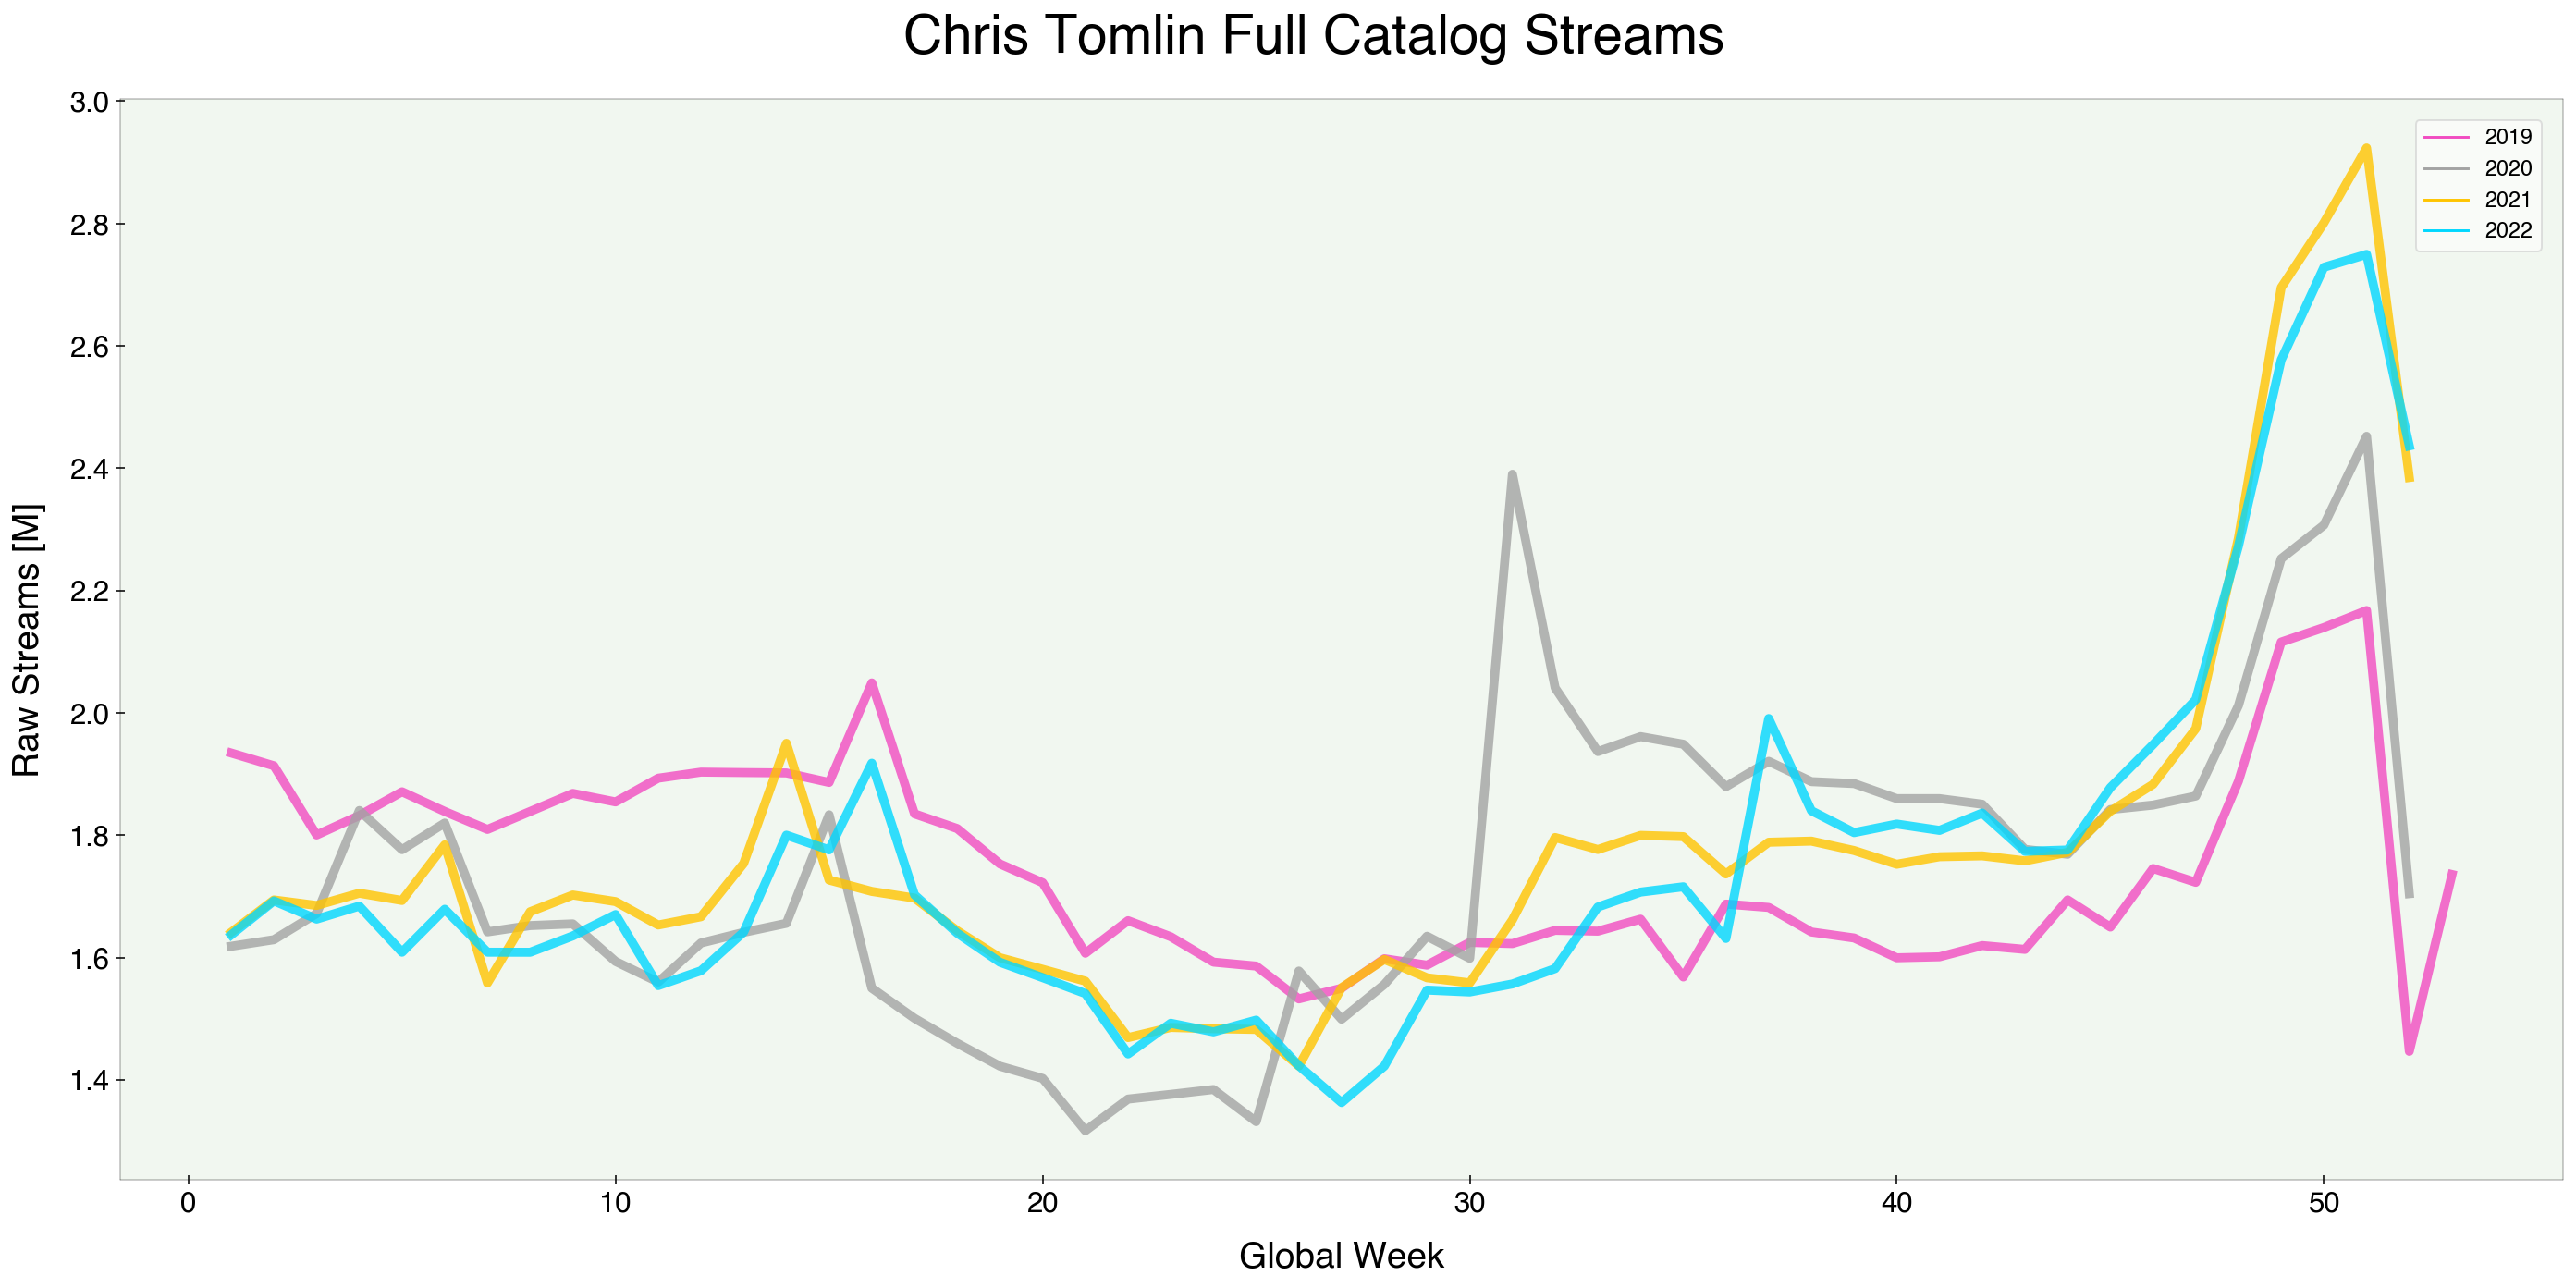

In [58]:
def plot_executive(df):

    df = df[df['year'].isin(years_list_extra[1:])]

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize = (20,10), dpi=140)
    title_string = f'{df.master_artist.unique()[0]} Full Catalog Streams'
    out_path_image = './outputs/' + title_string.lower().replace(' ', '_') + '.png'
    out_path_html = out_path_image.replace('.png', '.html')

    df = df.groupby(['year', 'week', 'transaction_date']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

    sns.lineplot(
        data=df, 
        ax=ax,
        x=df['week'],
        y=df['raw_stream_units'].div(1000000),
        hue=df["year"],
        ci=None,
        palette={i[0]: i[1] for i in list(zip(years_list_extra[1:], sns.color_palette('bright').as_hex()[-4:]))},
        lw=5,
        alpha=.8
    ).set(
        xlabel = 'Global Week',
        ylabel = 'Raw Streams [M]',
    )
    
    sns.despine(left=False, top=False, right=False)
    # ax.spines(True)ax.spines[i].set_linewidth(.2) 
    for i in ax.spines:
        ax.spines[i].set_linewidth(.2)  

    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout()
    ax.set_facecolor('#f1f7f0')
    ax.legend(borderaxespad=1, title='')
    plt.tick_params(axis='both', which='major', labelsize=16)

    # Remove Clustered Axis Labels
    # for label in ax.xaxis.get_ticklabels():
    #     if not ("15" in label.get_text() or  "30" in label.get_text()):
    #         label.set_visible(False)

    fig.savefig(out_path_image)
    handles, labels = plt.gca().get_legend_handles_labels()
    return out_path_image, out_path_html, title_string

out_path_image_1, out_path_html, title_string = plot_executive(df)

In [83]:
def plot_albums(df):

    # palette_dict = 

    df = df[df['year'].isin(years_list)]

    artist = df.master_artist.unique()[0]
    albums = df.master_album.unique()
    album_count = len(albums)

    fig, axes = plt.subplots(nrows=2,ncols=2,figsize = (20,10), dpi=140, sharex=True, sharey=False)

    title_string = f'{artist} Raw Streams By Album'
    out_path_image_1 = './outputs/' + title_string.lower().replace(' ', '_') + '.png'

    album_groups = df.groupby('master_album')
    group_keys = list(album_groups.groups.keys())

    for i, (ax, grp_name ) in enumerate(list(zip(axes.flatten(), group_keys))):
        df_grp = album_groups.get_group(grp_name)
        df_grp = df_grp.groupby(['transaction_date', 'month_day']).raw_stream_units.sum().reset_index().sort_values('transaction_date')

        sns.lineplot(
            data=df_grp, 
            ax=ax,
            x=df_grp['month_day'],
            y=df_grp['raw_stream_units'].div(1000000),
            hue=df_grp["transaction_date"].dt.year,
            ci=None,
            palette = {i[0]: i[1] for i in list(zip(years_list, sns.color_palette('bright').as_hex()[-4:]))},
            lw=3,
            alpha=.7,
            # legend='brief'
        ).set(
            xlabel = None,
            ylabel = None,
            title = grp_name,
            
        )

        ax.legend(borderaxespad=1, title='')

        # ax.title(1, 1)

        # spine charts all the way around
        sns.despine(left=False, top=False, right=False)
  
        for i_spine in ax.spines:
            ax.spines[i_spine].set_linewidth(.2)  

        # print(i)
        # remove all but top left legend
        if i != 0:
            ax.get_legend().remove()

            

        # Remove Clustered Axis Labels
        # for label in ax.xaxis.get_ticklabels():
        #     if not ("15" in label.get_text() or  "30" in label.get_text()):
        #         label.set_visible(False)
        #     else:
        #         print(label.get_text())

        ax.set_facecolor('#f1f7f0')
        ax.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    

    axes[1][0].text(x=-4, y=-0.06,  s =f'Charts do not share Y-Axis',).set(fontsize=18, color='darkgray')
    
    # fig.text(x=-0.015, y=.6, rotation=90,  s =f'Charts do not share Y-Axis',).set(style='italic', fontsize=18, color='darkgray')
    fig.suptitle(title_string, size = 30, weight="bold", y=0.99, x=0.51)
    plt.tight_layout()
    fig.savefig(out_path_image_1)

    return out_path_image_1

# out_path_image_2 = plot_albums(df)

# plot_albums(df)

In [59]:
def rename_index_names(df):
    df.index.names = [name.replace('_', ' ').upper() for name in df.index.names]
    df.columns.names = [name.replace('_', ' ').upper() for name in df.columns.names]
    return df

def style_neg_pos_pct(v):
    if v > 0:
        color_value = 'green'
    elif v < 0:
        color_value = 'red'
    else:
        color_value = 'white'

    return f'color: {color_value}'

def style_neg_pos_int(v):
    if v == 0:
        color_value = 'white'
    else:
        color_value = 'black'

    return f'color: {color_value}'


def volume_stream_by_year(df):
    df = df[
        (df['year'].isin(years_list_extra[1:])) &
        (df['master_track'].isin(top_50)) & 
        (df['product_type'] != 'Bundle')
        ]

    df = df.pivot_table(
                    index=['master_track'], 
                    columns=['year'], 
                    values='raw_stream_units', 
                    aggfunc='sum',
                    )

    df['TOTAL'] = df.sum(1)
    df = df.sort_values('TOTAL', ascending=False)

    df.loc['TOTAL', :] = df.sum(0)

    df = rename_index_names(df)
    df_out = df.fillna(0).astype(int)

    volumes_index_order = df_out.index

    return df_out.style.format('{:,}').applymap(style_neg_pos_int), volumes_index_order



def percent_change_by_year(df, volumes_index_order):

    df = df[
            (df['year'].isin(years_list_extra)) &
            (df['master_track'].isin(top_50)) & 
            (df['product_type'] != 'Bundle')
            ]

    df = df.pivot_table(
                    index=['master_track'], 
                    columns=['year'], 
                    values='raw_stream_units', 
                    aggfunc='sum',
                    )

    df.loc['TOTAL', :] = df.sum(0)

    df = df.pct_change(axis='columns').loc[:, years_list_extra[1:]]
    df = df.reindex(volumes_index_order)

    return df.style.format('{:,.1%}').applymap(style_neg_pos_pct)


In [60]:
def consumption_table(df):

    df = df.pivot_table(index='country', columns='year', values='album_adjusted_units', aggfunc='sum')
    df = df.loc[:, years_list_extra[1:]]



    df['Total Consumption'] = df.sum(1)
    df = df.sort_values('Total Consumption', ascending=False)
    df.loc['Total Consumption'] = df.sum(0)

    
    df = df.fillna(0).astype(int)
    
    df = rename_index_names(df)

    return df.style.format('{:,}')#.applymap(style_neg_pos_int)




In [61]:
def create_image_tag_data(image_path):

    image_bytes = open(str(image_path), 'rb').read()
    data_uri = base64.b64encode(image_bytes).decode('utf-8')
    img_tag = '<img style="margin-top: 80px;" src="data:image/png;base64,{0}">'.format(data_uri)

    return img_tag


In [62]:
df_volumes, volumes_index_order = volume_stream_by_year(df)
df_percent = percent_change_by_year(df, volumes_index_order=volumes_index_order)
df_consumption = consumption_table(df)

In [63]:
html_string = '''
<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=0.5" /> 
<style> 
  #centered {{clear:both; margin: auto; zoom: 75%;}}
  html {{font-family:helvetica; margin: auto; margin-bottom: 100px; margin-bottom: 100px;}}
  png {{margin-top: 80px; margin-bottom: 80px;}}

  tables1, tables2 {{ display: inline-block; padding: 5px; border-collapse: collapse;}}
  tables3 {{ display: inline-block; padding: 5px; border-collapse: collapse;}}



  h3 {{ font-size: 30pt; text-align:left; font-weight: normal;}}
  thead {{
    font-size: 20pt; font-weight: normal; text-align:center; vertical-align: center; padding: 5px; border-bottom:1px solid black; color: black; background-color: #fafaf0;
    }}
  th {{
    font-size: 20pt; font-weight: normal; text-align:center; vertical-align: center; padding: 5px; border-bottom:1px solid black; color: black; background-color: #f1f7f0; 
    padding-left: 100px;
    }}
  td {{
    font-size: 15pt; text-align:right; vertical-align: center; padding: 10px; border-bottom:1px solid black; background-color: white;
    padding-left: 100px; margin: 0; font-weight: normal;
    }}

    .blank, level0, level1 {{background-color: #ffffff;}}

    
</style>
</head>
  <body id="centered">
    <center><png>{image_1}</png></center>
  <hr>
  <center>
  <TABLES>
    <tables1 style="margin-top: 20px;">
    <center><h3>Top 50 Stream Pct +/-</h3></center>
    <center>{table1}</center>
    </tables1>
    
    <tables2 style="margin-top: 20px;">
    <center><h3>Top 50 Stream Volumes</h3></center>
    <center>{table2}</center>
    </tables2>
    
    <tables3 style="margin-top: 20px;">
    <center><h3>Total Consumption</h3></center>
    <center>{table3}</center>
    </tables3>
    

    <TABLES>

  </center>
  </body>
</html>
'''.format(
        image_1=create_image_tag_data(out_path_image_1),
        table1=df_percent.to_html(),
        table2=df_volumes.to_html(),
        table3=df_consumption.to_html(),
        )

with open(out_path_html, 'w') as f:
    f.write(html_string)

[2018, 2019, 2020, 2021, 2022]

In [75]:
# df.pivot_table(index=['master_artist', 'master_track']).agg(
#     {'year': 'first'}
# )
out_path_excel = out_path_html.replace('.html', '_data.xlsx')


df[df['year'].isin(years_list_extra[1:])].groupby(['year', 'master_track']).agg({'raw_stream_units': 'sum', 'album_adjusted_units': 'sum'}).reset_index().to_excel(out_path_excel, index=False)

In [76]:
from appscript import app, k
from mactypes import Alias
from pathlib import Path

def create_message_with_attachment():
    subject = f'{title_string}'
    body = f'<br>\n{html_string}' \
        .replace('padding-left: 100px', 'padding-left: 20px') \
        .replace('font-size: 20pt', 'font-size: 15pt') \
        .replace('font-size: 15pt', 'font-size: 10pt') \
        .replace('padding: 10px', 'padding: 2px') \
        .replace('<hr>', '') \
        .replace('<center>', '') \
        .replace('</center>', '') \
        .replace('font-size: 30pt;', 'font-size: 20pt;') 
    to_recip = []

    msg = Message(subject=subject, body=body, to_recip=to_recip, cc_recip=['david.sylvester@umusic.com'])

    # attach file
    e = str(out_path_excel)
    p = str(out_path_html)
    
    msg.add_attachment(e)
    msg.add_attachment(p)
    

    msg.show()

class Outlook(object):
    def __init__(self):
        self.client = app('Microsoft Outlook')

class Message(object):
    def __init__(self, parent=None, subject='', body='', to_recip=[], cc_recip=[], show_=True):

        if parent is None: parent = Outlook()
        client = parent.client

        self.msg = client.make(
            new=k.outgoing_message,
            with_properties={k.subject: subject, k.content: body})

        self.add_recipients(emails=to_recip, type_='to')
        self.add_recipients(emails=cc_recip, type_='cc')

        if show_: self.show()

    def show(self):
        self.msg.open()
        self.msg.activate()

    def add_attachment(self, p):
        # p is a Path() obj, could also pass string

        p = Alias(str(p)) # convert string/path obj to POSIX/mactypes path

        attach = self.msg.make(new=k.attachment, with_properties={k.file: p})

    def add_recipients(self, emails, type_='to'):
        if not isinstance(emails, list): emails = [emails]
        for email in emails:
            self.add_recipient(email=email, type_=type_)

    def add_recipient(self, email, type_='to'):
        msg = self.msg

        if type_ == 'to':
            recipient = k.to_recipient
        elif type_ == 'cc':
            recipient = k.cc_recipient

        msg.make(new=recipient, with_properties={k.email_address: {k.address: email}})

In [77]:
create_message_with_attachment()

In [ ]:
## TABLE 1 (RAW STREAM)
def raw_stream_units_table(df):
    df = df[df['usage_group'].str.contains('Streaming')]
    df_list = []
    sub_totals = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='raw_stream_units', aggfunc='sum')
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()
    return final_df.astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index



## TABLE 2 (TRACK DOWNLOADS)
def track_download_table(df):
    df = df[df['usage_group'].str.contains('Track')]
    df_list = []
    sub_totals = []
    # total_indexes = []
    album_groups = df.groupby(['master_album'])
    for grp in album_groups.groups.keys():

        df1 = album_groups.get_group(grp)
        df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
        # display(df2.head())
        df2['TOTAL'] = df2.sum(1)
        df2 = df2.sort_values(['master_album', 'TOTAL'], ascending=False, axis=0)
        grp_subtotal = df2.sum()
        df2.loc[(grp, f'SUB TOTAL'), :] = grp_subtotal
        # display(df2.head())
        df_list.append(df2)
        sub_totals.append(grp_subtotal)

    final_df = pd.concat(df_list, axis=0).fillna(0)
    final_df.loc[('ALL ALBUM', 'GRAND TOTAL'), :] = sum(sub_totals)
    reset_df = final_df.reset_index()

    return final_df.fillna(0).astype(int), reset_df[reset_df['master_track'].str.contains('TOTAL')].index

## TABLE 3 (TOTAL CONSUMPTION)
def total_consumption_table(df):
    # df2 = df1.pivot_table(index=['master_album', 'master_track'], columns=['account'], values='units', aggfunc='sum')
    df1 = df.pivot_table(index=['master_album'], values='album_adjusted_units', aggfunc='sum')

    df1 = df1.sort_values('album_adjusted_units', ascending=False)
    df1.loc['GRAND TOTAL', :] = df1.sum(0)

    print(df1.shape)

    return df1.astype(int)

# df_raw_streams, df_raw_streams_indexes = raw_stream_units_table(df)

# df_track_downloads, df_track_downloads_indexes = track_download_table(df)

# df_total_consumption = total_consumption_table(df)